In [1]:
import xarray as xr
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Polygon
from scipy.stats import pearsonr
import geopandas as gpd
import sys
from mpl_toolkits.basemap import Basemap
import pyproj
from pyproj import Proj, transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

import scipy.stats as st 

In [2]:
# Define the source and target CRS
src_crs = Proj('EPSG:4326')
target_crs = Proj(proj='latlong', datum='WGS84')

# Now, use lon_values_reprojected and lat_values_reprojected in your plt.imshow() and shapefile plotting functions

# Load the shapefile using geopandas
shapefile_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/dangermond_bound/dan_bound2.shp"
gdf = gpd.read_file(shapefile_path)


# Plot Chl trait maps

In [6]:
# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file path
#base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax.nc"
base_file_path1 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/chl_aviris_dangermond_clima_fit_time_{}_reg.nc"

# Open the NetCDF file for TROPOMI dataset
#file2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.001deg_regrid_Dangermond_tll_clipped_458_492.nc"
base_file_path2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/masked_chl_aviris_dangermond_time_{}.nc"


#ds2 = xr.open_dataset(file2, decode_times=True)

# Save dates, mean, and std values to a text file
try:
    file = open('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/chl_statistics_hr_clima_fit_prescribed_lai_ci.txt', 'w')
    file.write('Date\tMean Observed\tStd Observed\tCI95 Observed\tMean Predicted\tStd Predicted\tCI95 Predicted\n')
except Exception as e:
    print(f"Error: {e}")


# Initialize empty lists to accumulate data points
observed_all = []
predicted_all = []

# Initialize a list to store individual spatial differences
spatial_diff_list = []

for i, target_date_str in enumerate(dates):
    # Construct file1 dynamically based on the time step index (i)
    file1 = base_file_path1.format(str(i).zfill(2))
    file2 = base_file_path2.format(str(i).zfill(2))


    # Open dataset for file1
    ds1 = xr.open_dataset(file1, decode_times=False)  
    ds2 = xr.open_dataset(file2, decode_times=False)  

    
    target_date = pd.Timestamp(target_date_str).value / 10**9  # Convert to seconds since epoch
    print('target_date=',target_date)
    # Convert target_date to datetime64[ns]
    target_date = pd.to_datetime(target_date, unit='s')
    print('target_date=',target_date)



    # Calculate the average time of the selected data in ds2_selected

    ds1_selected = ds1['chl']*(ds1['chl']/ds1['chl'])
    ds2_selected = ds2['chl']

      
    # Filter out NaN values
    valid_indices = ~np.isnan(ds2_selected.values.flatten()) & ~np.isnan(ds1_selected.values.flatten())
    if valid_indices.any():
        observed = ds2_selected.values.flatten()[valid_indices]
        predicted = ds1_selected.values.flatten()[valid_indices]
        
        print("Observed shape before cleaning:", observed.shape)
        print("Predicted shape before cleaning:", predicted.shape)

        observed = observed[~np.isnan(observed)]
        predicted = predicted[~np.isnan(predicted)]

        print("Observed shape after cleaning:", observed.shape)
        print("Predicted shape after cleaning:", predicted.shape)


        print('mean obs =', np.mean(observed))
        print('mean pred =', np.mean(predicted))

        # Calculate spatial differences
        spatial_diff_num =  predicted 

        # Squeeze the array to remove the singleton dimension
        spatial_diff_num = np.squeeze(spatial_diff_num)   
        
        # Calculate spatial differences
        spatial_diff =  ds1_selected.values
        
        # Squeeze the array to remove the singleton dimension
        spatial_diff = np.squeeze(spatial_diff)
        
        
        # Calculate spatial differences and append them to the list
        spatial_diff_list.append(spatial_diff)

        #Get latitude and longitude values
        lat_values = ds2_selected['lat'].values
        lon_values = ds2_selected['lon'].values
        
        # Calculate metrics
        mae = mean_absolute_error(observed, predicted)

        # Calculate mean, std, bias, RMSE, and R²
        mean_observed = np.mean(observed)
        mean_predicted = np.mean(predicted)
        std_observed = np.std(observed)
        std_predicted = np.std(predicted)
        bias = mean_predicted - mean_observed
        rmse = np.sqrt(np.mean((predicted - observed)**2))
        slope, intercept, r_value, p_value, std_err = linregress(observed, predicted)
        r2 = r_value**2


        
        #plt.imshow(spatial_diff)
        #plt.colorbar()
        #plt.show()
        #plt.close()
        print("mae:", mae)
        print("bias:", bias)
        print("RMSE:", rmse)
        print("R^2 Score:", r2)

        # create 95% confidence interval 
        ci95_observed = st.t.interval(0.95, df=len(observed)-1, 
                        loc=np.mean(observed), 
                        scale=st.sem(observed)) 

        # create 95% confidence interval 
        ci95_predicted = st.t.interval(0.95, df=len(predicted)-1, 
                        loc=np.mean(predicted), 
                        scale=st.sem(predicted)) 
  
        # Append statistics for the current date to the file
        file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted}\t{bias}\t{rmse}\t{r2}\n')

        # Create a Basemap instance with the desired projection
        m = Basemap(projection='merc', llcrnrlat=lat_values.min(), urcrnrlat=lat_values.max(),
                llcrnrlon=lon_values.min(), urcrnrlon=lon_values.max(), resolution='c')

        x,y = np.meshgrid(lon_values, lat_values) 
        X,Y = m(x, y)
        
        # Define the number of decimal places for meridian and parallel labels
        decimal_places = 3

        # Define a custom formatter function to format the labels with the specified number of decimal places
        def format_labels(x, pos):
            return '{:.{decimal_places}f}'.format(x, decimal_places=decimal_places)


        # Create a figure and axes
        plt.figure(figsize=(8, 6))
        m.drawparallels(np.arange(-90.,91.,0.025), labels=[1,0,0,1],    dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        m.drawmeridians(np.arange(0., 360., 0.025), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        #m.drawcoastlines(color='0.6', linewidth=0.5)

        # Plot spatial differences using pcolormesh with Basemap
        cs = m.pcolormesh(X, Y, spatial_diff, cmap='YlGn', vmin=0, vmax=80.)

        vmin = 0.
        vmax = 80.
        cbar = m.colorbar(cs, pad='10%',ticks=np.linspace(vmin,vmax,5),format='%.2f')
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel(r'Chl ($\mu$g.cm$^{-2}$)', rotation=270, verticalalignment='center', color='black', size=16)
        cbar.solids.set_edgecolor("face")
        #cbar.set_clim(vmin,vmax)
        # Assuming cbar is your Colorbar object
        #cbar.ax.set_clim(vmin, vmax)
        cbar.ax.tick_params(labelsize='large')
        #gdf.plot(ax=m, linewidth=1, edgecolor='black', facecolor='none', legend=True)
        #m.readshapefile(shapefile_path,'Geometry')
        # Plot contour of Dangermond shapefile
        #m.readshapefile(shapefile_path, 'dan_bound2', linewidth=2, color='black')
        
        # Manually draw shapefile polygons on top of the contour plot
        for shape in gdf['geometry']:
            if shape.geom_type == 'Polygon':
                x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
                polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
                plt.gca().add_patch(polygon)

        # Plot spatial differences with latitude and longitude values on the y and x axes
        #plt.imshow(spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data range
    
        # Overlay shapefile contour on top of the spatial differences plot
        #gdf.plot(ax=plt.gca(), linewidth=1, edgecolor='black', facecolor='none', legend=True)


        # Set title, labels, and tick formatters
        plt.title(f'Date {target_date_str}',fontsize=14)
        #plt.xlabel('Longitude')
        #plt.ylabel('Latitude')
    

        # Add colorbar to the right of the plot
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.1)


        
        # Set 2 decimal places for latitude and longitude ticks
        #lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lat_values[x]))
        #lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lon_values[x]))
        
        
        # Get latitude and longitude values from your SIF data
        #lat_min, lat_max = lat_values.min(), lat_values.max()
        #lon_min, lon_max = lon_values.min(), lon_values.max()
        #print( lon_min, lon_max,lat_min, lat_max)
        
        # Set 4 ticks for latitude and longitude
        #num_ticks = 4
        #lat_indices = np.linspace(0, len(lat_values) - 1, num_ticks, dtype=int)
        #lon_indices = np.linspace(0, len(lon_values) - 1, num_ticks, dtype=int)

        # Set x and y ticks with actual lat and lon values formatted to 2 decimal places
        #plt.xticks(lon_indices, lon_values[lon_indices])
        #plt.yticks(lat_indices, lat_values[lat_indices])

        # Set formatted latitude and longitude tick labels
        #plt.gca().get_xaxis().set_major_formatter(lon_formatter)
        #plt.gca().get_yaxis().set_major_formatter(lat_formatter)
        


        # Add text box with statistics in the upper right corner
        bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
        plt.gca().text(0.95, 0.95, f'Mean: {mean_predicted:.2f}\nSTD: {std_predicted:.2f}',
                transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right',fontsize=14)
                


        # Invert the latitude axis
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        # Save the figure
        plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/chl_{i:02d}_trait_map_clima_fit.png',dpi=300)
        #plt.show()
        #sys.exit()
        
        # Close the figure to avoid displaying multiple plots at once
        plt.close()
        print('Figure spatial_differences_{i}.png saved!')
        

        # Filter out NaN values
        valid_indices = ~np.isnan(ds1_selected.values) & ~np.isnan(ds2_selected.values)
        observed = ds2_selected.values.reshape(-1)[valid_indices.reshape(-1)]
        predicted = ds1_selected.values.reshape(-1)[valid_indices.reshape(-1)]

        # Check if there are still valid values after filtering
        if len(observed) > 0 and len(predicted) > 0:
            # Accumulate observed and predicted values
            observed_all.extend(observed)
            predicted_all.extend(predicted)

        # Close the datasets to free up resources
        ds1.close()
        ds2_selected.close()
        
        print('Total matrix ammended!')
        print(spatial_diff_list)
    
    
# Calculate the average spatial difference after the loop
average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)  

mean_predicted = np.nanmean(average_spatial_diff)
std_predicted = np.nanstd(average_spatial_diff)

# Create a figure and axes
plt.figure(figsize=(8, 6))
m.drawparallels(np.arange(-90., 91., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)
m.drawmeridians(np.arange(0., 360., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)

# Plot spatial differences using pcolormesh with Basemap
cs = m.pcolormesh(X, Y, average_spatial_diff, cmap='YlGn', vmin=0, vmax=80)

vmin = 0
vmax = 80
cbar = m.colorbar(cs, pad='10%', ticks=np.linspace(vmin, vmax, 5), format='%.2f')
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel(r'Chl ($\mu$g.cm$^{-2}$)', rotation=270, verticalalignment='center', color='black', size=16)
cbar.solids.set_edgecolor("face")
cbar.ax.tick_params(labelsize='large')

# Manually draw shapefile polygons on top of the contour plot
for shape in gdf['geometry']:
    if shape.geom_type == 'Polygon':
       x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
       polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
       plt.gca().add_patch(polygon)

# Set title, labels, and tick formatters
plt.title(f'Mean', fontsize=14)

# Add text box with statistics in the upper right corner
bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
plt.gca().text(0.95, 0.95, f'Mean: {mean_predicted:.2f}\nSTD: {std_predicted:.2f}',
           transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right', fontsize=14)


plt.tight_layout()
# Save the figure
plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/chl_mean_trait_clima_fit.png', dpi=300)


# Close the figure to avoid displaying multiple plots at once
plt.close()
print(f'Figure pft_spatial_differences_{i}.png saved!')


target_date= 1645660800.0
target_date= 2022-02-24 00:00:00
Observed shape before cleaning: (102821,)
Predicted shape before cleaning: (102821,)
Observed shape after cleaning: (102821,)
Predicted shape after cleaning: (102821,)
mean obs = 49.19883
mean pred = 49.198837
mae: 20.124727
bias: 7.6293945e-06
RMSE: 23.036129
R^2 Score: 0.1073972511815568
Figure spatial_differences_{i}.png saved!
Total matrix ammended!
[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)]
target_date= 1646006400.0
target_date= 2022-02-28 00:00:00
Observed shape before cleaning: (102754,)
Predicted shape before cleaning: (102754,)
Observed shape after cleaning: (102754,)
Predicted shape after cleaning: (102754,)
mean obs = 46.934517
mean pred = 46.93451
mae: 19.875961
bias: -

/tmp/ipykernel_2938784/933992310.py:265: RuntimeWarning: Mean of empty slice
  average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)


Figure pft_spatial_differences_12.png saved!


# Plot Chl PFT maps

In [7]:
# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file path
#base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax.nc"
base_file_path1 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/chl_aviris_dangermond_clima_fit_time_{}_reg.nc"

# Open the NetCDF file for TROPOMI dataset
#file2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.001deg_regrid_Dangermond_tll_clipped_458_492.nc"
base_file_path2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/masked_chl_aviris_dangermond_time_{}.nc"


#ds2 = xr.open_dataset(file2, decode_times=True)

# Save dates, mean, and std values to a text file
try:
    file = open('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/chl_statistics_pft_hr_clima_fit.txt', 'w')
    file.write('Date\tMean Observed\tStd Observed\tCI95 Observed\tMean Predicted\tStd Predicted\tCI95 Predicted\n')
except Exception as e:
    print(f"Error: {e}")


# Initialize empty lists to accumulate data points
observed_all = []
predicted_all = []

# Initialize a list to store individual spatial differences
spatial_diff_list = []

for i, target_date_str in enumerate(dates):
    # Construct file1 dynamically based on the time step index (i)
    file1 = base_file_path1.format(str(i).zfill(2))
    file2 = base_file_path2.format(str(i).zfill(2))


    # Open dataset for file1
    ds1 = xr.open_dataset(file1, decode_times=False)  
    ds2 = xr.open_dataset(file2, decode_times=False)  

    
    target_date = pd.Timestamp(target_date_str).value / 10**9  # Convert to seconds since epoch
    print('target_date=',target_date)
    # Convert target_date to datetime64[ns]
    target_date = pd.to_datetime(target_date, unit='s')
    print('target_date=',target_date)



    # Calculate the average time of the selected data in ds2_selected

    ds1_selected = ds1['chl']
    ds2_selected = ds2['chl']

      
    # Filter out NaN values
    valid_indices = ~np.isnan(ds2_selected.values.flatten()) & ~np.isnan(ds1_selected.values.flatten())
    if valid_indices.any():
        observed = ds2_selected.values.flatten()[valid_indices]
        predicted = ds1_selected.values.flatten()[valid_indices]
        
        print("Observed shape before cleaning:", observed.shape)
        print("Predicted shape before cleaning:", predicted.shape)

        observed = observed[~np.isnan(observed)]
        predicted = predicted[~np.isnan(predicted)]

        print("Observed shape after cleaning:", observed.shape)
        print("Predicted shape after cleaning:", predicted.shape)


        print('mean obs =', np.mean(observed))
        print('mean pred =', np.mean(predicted))

        # Calculate spatial differences
        spatial_diff_num =  observed 

        # Squeeze the array to remove the singleton dimension
        spatial_diff_num = np.squeeze(spatial_diff_num)   
        
        # Calculate spatial differences
        spatial_diff =  ds2_selected.values
        
        # Squeeze the array to remove the singleton dimension
        spatial_diff = np.squeeze(spatial_diff)
        
        
        # Calculate spatial differences and append them to the list
        spatial_diff_list.append(spatial_diff)

        #Get latitude and longitude values
        lat_values = ds2_selected['lat'].values
        lon_values = ds2_selected['lon'].values
        
        # Calculate metrics
        mae = mean_absolute_error(observed, predicted)

        # Calculate mean, std, bias, RMSE, and R²
        mean_observed = np.mean(observed)
        mean_predicted = np.mean(predicted)
        std_observed = np.std(observed)
        std_predicted = np.std(predicted)
        bias = mean_predicted - mean_observed
        rmse = np.sqrt(np.mean((predicted - observed)**2))
        slope, intercept, r_value, p_value, std_err = linregress(observed, predicted)
        r2 = r_value**2


        
        #plt.imshow(spatial_diff)
        #plt.colorbar()
        #plt.show()
        #plt.close()
        print("mae:", mae)
        print("bias:", bias)
        print("RMSE:", rmse)
        print("R^2 Score:", r2)

        # create 95% confidence interval 
        ci95_observed = st.t.interval(0.95, df=len(observed)-1, 
                        loc=np.mean(observed), 
                        scale=st.sem(observed)) 

        # create 95% confidence interval 
        ci95_predicted = st.t.interval(0.95, df=len(predicted)-1, 
                        loc=np.mean(predicted), 
                        scale=st.sem(predicted)) 
  
        # Append statistics for the current date to the file
        file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted}\t{bias}\t{rmse}\t{r2}\n')

        # Create a Basemap instance with the desired projection
        m = Basemap(projection='merc', llcrnrlat=lat_values.min(), urcrnrlat=lat_values.max(),
                llcrnrlon=lon_values.min(), urcrnrlon=lon_values.max(), resolution='c')

        x,y = np.meshgrid(lon_values, lat_values) 
        X,Y = m(x, y)
        
        # Define the number of decimal places for meridian and parallel labels
        decimal_places = 3

        # Define a custom formatter function to format the labels with the specified number of decimal places
        def format_labels(x, pos):
            return '{:.{decimal_places}f}'.format(x, decimal_places=decimal_places)


        # Create a figure and axes
        plt.figure(figsize=(8, 6))
        m.drawparallels(np.arange(-90.,91.,0.025), labels=[1,0,0,1],    dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        m.drawmeridians(np.arange(0., 360., 0.025), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        #m.drawcoastlines(color='0.6', linewidth=0.5)

        # Plot spatial differences using pcolormesh with Basemap
        cs = m.pcolormesh(X, Y, spatial_diff, cmap='YlGn', vmin=0, vmax=80.)

        vmin = 0.
        vmax = 80.
        cbar = m.colorbar(cs, pad='10%',ticks=np.linspace(vmin,vmax,5),format='%.2f')
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel(r'Chl ($\mu$g.cm$^{-2}$)', rotation=270, verticalalignment='center', color='black', size=16)
        cbar.solids.set_edgecolor("face")
        #cbar.set_clim(vmin,vmax)
        # Assuming cbar is your Colorbar object
        #cbar.ax.set_clim(vmin, vmax)
        cbar.ax.tick_params(labelsize='large')
        #gdf.plot(ax=m, linewidth=1, edgecolor='black', facecolor='none', legend=True)
        #m.readshapefile(shapefile_path,'Geometry')
        # Plot contour of Dangermond shapefile
        #m.readshapefile(shapefile_path, 'dan_bound2', linewidth=2, color='black')
        
        # Manually draw shapefile polygons on top of the contour plot
        for shape in gdf['geometry']:
            if shape.geom_type == 'Polygon':
                x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
                polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
                plt.gca().add_patch(polygon)

        # Plot spatial differences with latitude and longitude values on the y and x axes
        #plt.imshow(spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data range
    
        # Overlay shapefile contour on top of the spatial differences plot
        #gdf.plot(ax=plt.gca(), linewidth=1, edgecolor='black', facecolor='none', legend=True)


        # Set title, labels, and tick formatters
        plt.title(f'Date {target_date_str}',fontsize=14)
        #plt.xlabel('Longitude')
        #plt.ylabel('Latitude')
    

        # Add colorbar to the right of the plot
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.1)


        
        # Set 2 decimal places for latitude and longitude ticks
        #lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lat_values[x]))
        #lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lon_values[x]))
        
        
        # Get latitude and longitude values from your SIF data
        #lat_min, lat_max = lat_values.min(), lat_values.max()
        #lon_min, lon_max = lon_values.min(), lon_values.max()
        #print( lon_min, lon_max,lat_min, lat_max)
        
        # Set 4 ticks for latitude and longitude
        #num_ticks = 4
        #lat_indices = np.linspace(0, len(lat_values) - 1, num_ticks, dtype=int)
        #lon_indices = np.linspace(0, len(lon_values) - 1, num_ticks, dtype=int)

        # Set x and y ticks with actual lat and lon values formatted to 2 decimal places
        #plt.xticks(lon_indices, lon_values[lon_indices])
        #plt.yticks(lat_indices, lat_values[lat_indices])

        # Set formatted latitude and longitude tick labels
        #plt.gca().get_xaxis().set_major_formatter(lon_formatter)
        #plt.gca().get_yaxis().set_major_formatter(lat_formatter)
        


        # Add text box with statistics in the upper right corner
        bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
        plt.gca().text(0.95, 0.95, f'Mean: {mean_predicted:.2f}\nSTD: {std_predicted:.2f}',
                transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right',fontsize=14)
                


        # Invert the latitude axis
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        # Save the figure
        plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/chl_{i}_pft_clima_fit.png',dpi=300)
        #plt.show()
        #sys.exit()
        
        # Close the figure to avoid displaying multiple plots at once
        plt.close()
        print('Figure spatial_differences_{i}.png saved!')
        

        # Filter out NaN values
        valid_indices = ~np.isnan(ds1_selected.values) & ~np.isnan(ds2_selected.values)
        observed = ds2_selected.values.reshape(-1)[valid_indices.reshape(-1)]
        predicted = ds1_selected.values.reshape(-1)[valid_indices.reshape(-1)]

        # Check if there are still valid values after filtering
        if len(observed) > 0 and len(predicted) > 0:
            # Accumulate observed and predicted values
            observed_all.extend(observed)
            predicted_all.extend(predicted)

        # Close the datasets to free up resources
        ds1.close()
        ds2_selected.close()
        
        print('Total matrix ammended!')
        print(spatial_diff_list)
    
    
# Calculate the average spatial difference after the loop
average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)  

mean_predicted = np.nanmean(average_spatial_diff)
std_predicted = np.nanstd(average_spatial_diff)

# Create a figure and axes
plt.figure(figsize=(8, 6))
m.drawparallels(np.arange(-90., 91., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)
m.drawmeridians(np.arange(0., 360., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)

# Plot spatial differences using pcolormesh with Basemap
cs = m.pcolormesh(X, Y, average_spatial_diff, cmap='YlGn', vmin=0, vmax=80)

vmin = 0
vmax = 80
cbar = m.colorbar(cs, pad='10%', ticks=np.linspace(vmin, vmax, 5), format='%.2f')
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel(r'Chl ($\mu$g.cm$^{-2}$)', rotation=270, verticalalignment='center', color='black', size=16)
cbar.solids.set_edgecolor("face")
cbar.ax.tick_params(labelsize='large')

# Manually draw shapefile polygons on top of the contour plot
for shape in gdf['geometry']:
    if shape.geom_type == 'Polygon':
       x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
       polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
       plt.gca().add_patch(polygon)

# Set title, labels, and tick formatters
plt.title(f'Mean', fontsize=14)

# Add text box with statistics in the upper right corner
bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
plt.gca().text(0.95, 0.95, f'Mean: {mean_predicted:.2f}\nSTD: {std_predicted:.2f}',
           transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right', fontsize=14)


plt.tight_layout()
# Save the figure
plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/chl_mean_pft_clima_fit.png', dpi=300)


# Close the figure to avoid displaying multiple plots at once
plt.close()
print(f'Figure pft_spatial_differences_{i}.png saved!')


target_date= 1645660800.0
target_date= 2022-02-24 00:00:00
Observed shape before cleaning: (102821,)
Predicted shape before cleaning: (102821,)
Observed shape after cleaning: (102821,)
Predicted shape after cleaning: (102821,)
mean obs = 49.19883
mean pred = 49.198837
mae: 20.124727
bias: 7.6293945e-06
RMSE: 23.036129
R^2 Score: 0.1073972511815568
Figure spatial_differences_{i}.png saved!
Total matrix ammended!
[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)]
target_date= 1646006400.0
target_date= 2022-02-28 00:00:00
Observed shape before cleaning: (102754,)
Predicted shape before cleaning: (102754,)
Observed shape after cleaning: (102754,)
Predicted shape after cleaning: (102754,)
mean obs = 46.934517
mean pred = 46.93451
mae: 19.875961
bias: -

/tmp/ipykernel_2938784/2248445792.py:265: RuntimeWarning: Mean of empty slice
  average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)


Figure pft_spatial_differences_12.png saved!


# Plotting Chl PFT - Trait

In [3]:
# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file path
#base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax.nc"
base_file_path1 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/chl_aviris_dangermond_clima_fit_time_{}_reg.nc"

# Open the NetCDF file for TROPOMI dataset
#file2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.001deg_regrid_Dangermond_tll_clipped_458_492.nc"
base_file_path2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/masked_chl_aviris_dangermond_time_{}.nc"


#ds2 = xr.open_dataset(file2, decode_times=True)

# Save dates, mean, and std values to a text file
try:
    file = open('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/chl_statistics_pft_minus_trait_clima_fit_hr.txt', 'w')
    file.write('Date\tMean Observed\tStd Observed\tCI95 Observed\tMean Predicted\tStd Predicted\tCI95 Predicted\n')
except Exception as e:
    print(f"Error: {e}")


# Initialize empty lists to accumulate data points
observed_all = []
predicted_all = []

# Initialize a list to store individual spatial differences
spatial_diff_list = []

for i, target_date_str in enumerate(dates):
    # Construct file1 dynamically based on the time step index (i)
    file1 = base_file_path1.format(str(i).zfill(2))
    file2 = base_file_path2.format(str(i).zfill(2))


    # Open dataset for file1
    ds1 = xr.open_dataset(file1, decode_times=False)  
    ds2 = xr.open_dataset(file2, decode_times=False)  

    
    target_date = pd.Timestamp(target_date_str).value / 10**9  # Convert to seconds since epoch
    print('target_date=',target_date)
    # Convert target_date to datetime64[ns]
    target_date = pd.to_datetime(target_date, unit='s')
    print('target_date=',target_date)



    # Calculate the average time of the selected data in ds2_selected

    ds1_selected = ds1['chl']
    ds2_selected = ds2['chl']

      
    # Filter out NaN values
    valid_indices = ~np.isnan(ds2_selected.values.flatten()) & ~np.isnan(ds1_selected.values.flatten())
    if valid_indices.any():
        observed = ds2_selected.values.flatten()[valid_indices]
        predicted = ds1_selected.values.flatten()[valid_indices]
        
        print("Observed shape before cleaning:", observed.shape)
        print("Predicted shape before cleaning:", predicted.shape)

        observed = observed[~np.isnan(observed)]
        predicted = predicted[~np.isnan(predicted)]

        print("Observed shape after cleaning:", observed.shape)
        print("Predicted shape after cleaning:", predicted.shape)


        print('mean obs =', np.mean(observed))
        print('mean pred =', np.mean(predicted))

        # Calculate spatial differences
        spatial_diff_num =  observed - predicted

        # Squeeze the array to remove the singleton dimension
        spatial_diff_num = np.squeeze(spatial_diff_num)   
        
        # Calculate spatial differences
        spatial_diff =  ds2_selected.values - ds1_selected.values
        
        # Squeeze the array to remove the singleton dimension
        spatial_diff = np.squeeze(spatial_diff)
        
        
        # Calculate spatial differences and append them to the list
        spatial_diff_list.append(spatial_diff)

        #Get latitude and longitude values
        lat_values = ds2_selected['lat'].values
        lon_values = ds2_selected['lon'].values
        
        # Calculate metrics
        mae = mean_absolute_error(observed, predicted)

        # Calculate mean, std, bias, RMSE, and R²
        mean_observed = np.mean(observed)
        mean_predicted = np.mean(predicted)
        mean = np.mean(spatial_diff_num)
        std_observed = np.std(observed)
        std_predicted = np.std(predicted)
        std = np.std(spatial_diff_num)  
        bias = mean_predicted - mean_observed
        rmse = np.sqrt(np.mean((predicted - observed)**2))
        slope, intercept, r_value, p_value, std_err = linregress(observed, predicted)
        r2 = r_value**2


        
        #plt.imshow(spatial_diff)
        #plt.colorbar()
        #plt.show()
        #plt.close()
        print("mae:", mae)
        print("bias:", bias)
        print("RMSE:", rmse)
        print("R^2 Score:", r2)

        # create 95% confidence interval 
        ci95_observed = st.t.interval(0.95, df=len(observed)-1, 
                        loc=np.mean(observed), 
                        scale=st.sem(observed)) 

        # create 95% confidence interval 
        ci95_predicted = st.t.interval(0.95, df=len(predicted)-1, 
                        loc=np.mean(predicted), 
                        scale=st.sem(predicted)) 
  
        # Append statistics for the current date to the file
        file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted}\t{bias}\t{rmse}\t{r2}\n')

        # Create a Basemap instance with the desired projection
        m = Basemap(projection='merc', llcrnrlat=lat_values.min(), urcrnrlat=lat_values.max(),
                llcrnrlon=lon_values.min(), urcrnrlon=lon_values.max(), resolution='c')

        x,y = np.meshgrid(lon_values, lat_values) 
        X,Y = m(x, y)
        
        # Define the number of decimal places for meridian and parallel labels
        decimal_places = 3

        # Define a custom formatter function to format the labels with the specified number of decimal places
        def format_labels(x, pos):
            return '{:.{decimal_places}f}'.format(x, decimal_places=decimal_places)


        # Create a figure and axes
        plt.figure(figsize=(8, 6))
        m.drawparallels(np.arange(-90.,91.,0.025), labels=[1,0,0,1],    dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        m.drawmeridians(np.arange(0., 360., 0.025), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        #m.drawcoastlines(color='0.6', linewidth=0.5)

        # Plot spatial differences using pcolormesh with Basemap
        cs = m.pcolormesh(X, Y, spatial_diff, cmap='coolwarm', vmin=-40, vmax=40.)

        vmin = -40.
        vmax = 40.
        cbar = m.colorbar(cs, pad='10%',ticks=np.linspace(vmin,vmax,5),format='%.2f')
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel(r'Chl difference ($\mu$g.cm$^{-2}$)', rotation=270, verticalalignment='center', color='black', size=16)
        cbar.solids.set_edgecolor("face")
        #cbar.set_clim(vmin,vmax)
        # Assuming cbar is your Colorbar object
        #cbar.ax.set_clim(vmin, vmax)
        cbar.ax.tick_params(labelsize='large')
        #gdf.plot(ax=m, linewidth=1, edgecolor='black', facecolor='none', legend=True)
        #m.readshapefile(shapefile_path,'Geometry')
        # Plot contour of Dangermond shapefile
        #m.readshapefile(shapefile_path, 'dan_bound2', linewidth=2, color='black')
        
        # Manually draw shapefile polygons on top of the contour plot
        for shape in gdf['geometry']:
            if shape.geom_type == 'Polygon':
                x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
                polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
                plt.gca().add_patch(polygon)

        # Plot spatial differences with latitude and longitude values on the y and x axes
        #plt.imshow(spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data range
    
        # Overlay shapefile contour on top of the spatial differences plot
        #gdf.plot(ax=plt.gca(), linewidth=1, edgecolor='black', facecolor='none', legend=True)


        # Set title, labels, and tick formatters
        plt.title(f'Date {target_date_str}',fontsize=14)
        #plt.xlabel('Longitude')
        #plt.ylabel('Latitude')
    

        # Add colorbar to the right of the plot
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.1)


        
        # Set 2 decimal places for latitude and longitude ticks
        #lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lat_values[x]))
        #lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lon_values[x]))
        
        
        # Get latitude and longitude values from your SIF data
        #lat_min, lat_max = lat_values.min(), lat_values.max()
        #lon_min, lon_max = lon_values.min(), lon_values.max()
        #print( lon_min, lon_max,lat_min, lat_max)
        
        # Set 4 ticks for latitude and longitude
        #num_ticks = 4
        #lat_indices = np.linspace(0, len(lat_values) - 1, num_ticks, dtype=int)
        #lon_indices = np.linspace(0, len(lon_values) - 1, num_ticks, dtype=int)

        # Set x and y ticks with actual lat and lon values formatted to 2 decimal places
        #plt.xticks(lon_indices, lon_values[lon_indices])
        #plt.yticks(lat_indices, lat_values[lat_indices])

        # Set formatted latitude and longitude tick labels
        #plt.gca().get_xaxis().set_major_formatter(lon_formatter)
        #plt.gca().get_yaxis().set_major_formatter(lat_formatter)
        


        # Add text box with statistics in the upper right corner
        bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
        plt.gca().text(0.95, 0.95, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}',
                transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right',fontsize=14)
                


        # Invert the latitude axis
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        # Save the figure
        plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/chl_{i}_pft_minus_trait_clima_fit.png',dpi=300)
        #plt.show()
        #sys.exit()
        
        # Close the figure to avoid displaying multiple plots at once
        plt.close()
        print('Figure spatial_differences_{i}.png saved!')
        

        # Filter out NaN values
        valid_indices = ~np.isnan(ds1_selected.values) & ~np.isnan(ds2_selected.values)
        observed = ds2_selected.values.reshape(-1)[valid_indices.reshape(-1)]
        predicted = ds1_selected.values.reshape(-1)[valid_indices.reshape(-1)]

        # Check if there are still valid values after filtering
        if len(observed) > 0 and len(predicted) > 0:
            # Accumulate observed and predicted values
            observed_all.extend(observed)
            predicted_all.extend(predicted)

        # Close the datasets to free up resources
        ds1.close()
        ds2_selected.close()
        
        print('Total matrix ammended!')
        print(spatial_diff_list)
    
    
# Calculate the average spatial difference after the loop
average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)  

# Create a figure and axes
plt.figure(figsize=(8, 6))
m.drawparallels(np.arange(-90., 91., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)
m.drawmeridians(np.arange(0., 360., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)

# Plot spatial differences using pcolormesh with Basemap
cs = m.pcolormesh(X, Y, average_spatial_diff, cmap='coolwarm', vmin=-40, vmax=40)

vmin = -40
vmax = 40
cbar = m.colorbar(cs, pad='10%', ticks=np.linspace(vmin, vmax, 5), format='%.2f')
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel(r'Chl difference ($\mu$g.cm$^{-2}$)', rotation=270, verticalalignment='center', color='black', size=16)
cbar.solids.set_edgecolor("face")
cbar.ax.tick_params(labelsize='large')

# Manually draw shapefile polygons on top of the contour plot
for shape in gdf['geometry']:
    if shape.geom_type == 'Polygon':
       x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
       polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
       plt.gca().add_patch(polygon)

# Set title, labels, and tick formatters
plt.title(f'Mean', fontsize=14)

# Add text box with statistics in the upper right corner
bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
plt.gca().text(0.95, 0.95, f'Mean: {mean:.2f}\nSTD: {std:.2f}',
           transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right', fontsize=14)


plt.tight_layout()
# Save the figure
plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/chl_mean_pft_minus_trait_clima_fit.png', dpi=300)


# Close the figure to avoid displaying multiple plots at once
plt.close()
print(f'Figure pft_spatial_differences_{i}.png saved!')


target_date= 1645660800.0
target_date= 2022-02-24 00:00:00
Observed shape before cleaning: (102821,)
Predicted shape before cleaning: (102821,)
Observed shape after cleaning: (102821,)
Predicted shape after cleaning: (102821,)
mean obs = 49.19883
mean pred = 49.198837
mae: 20.124727
bias: 7.6293945e-06
RMSE: 23.036129
R^2 Score: 0.1073972511815568
Figure spatial_differences_{i}.png saved!
Total matrix ammended!
[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)]
target_date= 1646006400.0
target_date= 2022-02-28 00:00:00
Observed shape before cleaning: (102754,)
Predicted shape before cleaning: (102754,)
Observed shape after cleaning: (102754,)
Predicted shape after cleaning: (102754,)
mean obs = 46.934517
mean pred = 46.93451
mae: 19.875961
bias: -

/tmp/ipykernel_2940823/3570645998.py:267: RuntimeWarning: Mean of empty slice
  average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)


Figure pft_spatial_differences_12.png saved!


In [4]:
# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file path
#base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax.nc"
base_file_path1 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/chl_aviris_dangermond_clima_fit_time_{}_reg.nc"

# Open the NetCDF file for TROPOMI dataset
#file2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.001deg_regrid_Dangermond_tll_clipped_458_492.nc"
base_file_path2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/mean_masked_chl_aviris_dangermond_clima_fit.nc"


#ds2 = xr.open_dataset(file2, decode_times=True)

# Save dates, mean, and std values to a text file
try:
    file = open('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/chl_statistics_trait_minus_mean_pft_hr.txt', 'w')
    file.write('Date\tMean Observed\tStd Observed\tCI95 Observed\tMean Predicted\tStd Predicted\tCI95 Predicted\n')
except Exception as e:
    print(f"Error: {e}")


# Initialize empty lists to accumulate data points
observed_all = []
predicted_all = []

# Initialize a list to store individual spatial differences
spatial_diff_list = []

for i, target_date_str in enumerate(dates):
    # Construct file1 dynamically based on the time step index (i)
    file1 = base_file_path1.format(str(i).zfill(2))
    file2 = base_file_path2.format(str(i).zfill(2))


    # Open dataset for file1
    ds1 = xr.open_dataset(file1, decode_times=False)  
    ds2 = xr.open_dataset(file2, decode_times=False)  

    
    target_date = pd.Timestamp(target_date_str).value / 10**9  # Convert to seconds since epoch
    print('target_date=',target_date)
    # Convert target_date to datetime64[ns]
    target_date = pd.to_datetime(target_date, unit='s')
    print('target_date=',target_date)



    # Calculate the average time of the selected data in ds2_selected

    ds1_selected = ds1['chl']
    ds2_selected = ds2['chl']

      
    # Filter out NaN values
    valid_indices = ~np.isnan(ds2_selected.values.flatten()) & ~np.isnan(ds1_selected.values.flatten())
    if valid_indices.any():
        observed = ds2_selected.values.flatten()[valid_indices]
        predicted = ds1_selected.values.flatten()[valid_indices]
        
        print("Observed shape before cleaning:", observed.shape)
        print("Predicted shape before cleaning:", predicted.shape)

        observed = observed[~np.isnan(observed)]
        predicted = predicted[~np.isnan(predicted)]

        print("Observed shape after cleaning:", observed.shape)
        print("Predicted shape after cleaning:", predicted.shape)


        print('mean obs =', np.mean(observed))
        print('mean pred =', np.mean(predicted))

        # Calculate spatial differences
        spatial_diff_num =  observed - predicted

        # Squeeze the array to remove the singleton dimension
        spatial_diff_num = np.squeeze(spatial_diff_num)   
        
        # Calculate spatial differences
        spatial_diff =  ds1_selected.values - ds2_selected.values
        
        # Squeeze the array to remove the singleton dimension
        spatial_diff = np.squeeze(spatial_diff)
        
        
        # Calculate spatial differences and append them to the list
        spatial_diff_list.append(spatial_diff)

        #Get latitude and longitude values
        lat_values = ds2_selected['lat'].values
        lon_values = ds2_selected['lon'].values
        
        # Calculate metrics
        mae = mean_absolute_error(observed, predicted)

        # Calculate mean, std, bias, RMSE, and R²
        mean_observed = np.mean(observed)
        mean_predicted = np.mean(predicted)
        mean = np.mean(spatial_diff_num)
        std_observed = np.std(observed)
        std_predicted = np.std(predicted)
        std = np.std(spatial_diff_num)  
        bias = mean_predicted - mean_observed
        rmse = np.sqrt(np.mean((predicted - observed)**2))
        slope, intercept, r_value, p_value, std_err = linregress(observed, predicted)
        r2 = r_value**2


        
        #plt.imshow(spatial_diff)
        #plt.colorbar()
        #plt.show()
        #plt.close()
        print("mae:", mae)
        print("bias:", bias)
        print("RMSE:", rmse)
        print("R^2 Score:", r2)

        # create 95% confidence interval 
        ci95_observed = st.t.interval(0.95, df=len(observed)-1, 
                        loc=np.mean(observed), 
                        scale=st.sem(observed)) 

        # create 95% confidence interval 
        ci95_predicted = st.t.interval(0.95, df=len(predicted)-1, 
                        loc=np.mean(predicted), 
                        scale=st.sem(predicted)) 
  
        # Append statistics for the current date to the file
        file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted}\t{bias}\t{rmse}\t{r2}\n')

        # Create a Basemap instance with the desired projection
        m = Basemap(projection='merc', llcrnrlat=lat_values.min(), urcrnrlat=lat_values.max(),
                llcrnrlon=lon_values.min(), urcrnrlon=lon_values.max(), resolution='c')

        x,y = np.meshgrid(lon_values, lat_values) 
        X,Y = m(x, y)
        
        # Define the number of decimal places for meridian and parallel labels
        decimal_places = 3

        # Define a custom formatter function to format the labels with the specified number of decimal places
        def format_labels(x, pos):
            return '{:.{decimal_places}f}'.format(x, decimal_places=decimal_places)


        # Create a figure and axes
        plt.figure(figsize=(8, 6))
        m.drawparallels(np.arange(-90.,91.,0.025), labels=[1,0,0,1],    dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        m.drawmeridians(np.arange(0., 360., 0.025), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        #m.drawcoastlines(color='0.6', linewidth=0.5)

        # Plot spatial differences using pcolormesh with Basemap
        cs = m.pcolormesh(X, Y, spatial_diff, cmap='coolwarm', vmin=-40, vmax=40.)

        vmin = -40.
        vmax = 40.
        cbar = m.colorbar(cs, pad='10%',ticks=np.linspace(vmin,vmax,5),format='%.2f')
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel(r'Chl difference ($\mu$g.cm$^{-2}$)', rotation=270, verticalalignment='center', color='black', size=16)
        cbar.solids.set_edgecolor("face")
        #cbar.set_clim(vmin,vmax)
        # Assuming cbar is your Colorbar object
        #cbar.ax.set_clim(vmin, vmax)
        cbar.ax.tick_params(labelsize='large')
        #gdf.plot(ax=m, linewidth=1, edgecolor='black', facecolor='none', legend=True)
        #m.readshapefile(shapefile_path,'Geometry')
        # Plot contour of Dangermond shapefile
        #m.readshapefile(shapefile_path, 'dan_bound2', linewidth=2, color='black')
        
        # Manually draw shapefile polygons on top of the contour plot
        for shape in gdf['geometry']:
            if shape.geom_type == 'Polygon':
                x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
                polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
                plt.gca().add_patch(polygon)

        # Plot spatial differences with latitude and longitude values on the y and x axes
        #plt.imshow(spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data range
    
        # Overlay shapefile contour on top of the spatial differences plot
        #gdf.plot(ax=plt.gca(), linewidth=1, edgecolor='black', facecolor='none', legend=True)


        # Set title, labels, and tick formatters
        plt.title(f'Date {target_date_str}',fontsize=14)
        #plt.xlabel('Longitude')
        #plt.ylabel('Latitude')
    

        # Add colorbar to the right of the plot
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.1)


        
        # Set 2 decimal places for latitude and longitude ticks
        #lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lat_values[x]))
        #lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lon_values[x]))
        
        
        # Get latitude and longitude values from your SIF data
        #lat_min, lat_max = lat_values.min(), lat_values.max()
        #lon_min, lon_max = lon_values.min(), lon_values.max()
        #print( lon_min, lon_max,lat_min, lat_max)
        
        # Set 4 ticks for latitude and longitude
        #num_ticks = 4
        #lat_indices = np.linspace(0, len(lat_values) - 1, num_ticks, dtype=int)
        #lon_indices = np.linspace(0, len(lon_values) - 1, num_ticks, dtype=int)

        # Set x and y ticks with actual lat and lon values formatted to 2 decimal places
        #plt.xticks(lon_indices, lon_values[lon_indices])
        #plt.yticks(lat_indices, lat_values[lat_indices])

        # Set formatted latitude and longitude tick labels
        #plt.gca().get_xaxis().set_major_formatter(lon_formatter)
        #plt.gca().get_yaxis().set_major_formatter(lat_formatter)
        


        # Add text box with statistics in the upper right corner
        bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
        #plt.gca().text(0.95, 0.95, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}',
        plt.gca().text(0.95, 0.95, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}',
                transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right',fontsize=14)
                


        # Invert the latitude axis
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        # Save the figure
        plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/chl_{i}_trait_minus_pft_mean_clima_fit.png',dpi=300)
        #plt.show()
        #sys.exit()
        
        # Close the figure to avoid displaying multiple plots at once
        plt.close()
        print('Figure spatial_differences_{i}.png saved!')
        

        # Filter out NaN values
        valid_indices = ~np.isnan(ds1_selected.values) & ~np.isnan(ds2_selected.values)
        observed = ds2_selected.values.reshape(-1)[valid_indices.reshape(-1)]
        predicted = ds1_selected.values.reshape(-1)[valid_indices.reshape(-1)]

        # Check if there are still valid values after filtering
        if len(observed) > 0 and len(predicted) > 0:
            # Accumulate observed and predicted values
            observed_all.extend(observed)
            predicted_all.extend(predicted)

        # Close the datasets to free up resources
        ds1.close()
        ds2_selected.close()
        
        print('Total matrix ammended!')
        print(spatial_diff_list)
    
    
# Calculate the average spatial difference after the loop
average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)  
mean = np.nanmean(average_spatial_diff)
std = np.nanstd(average_spatial_diff)

# Create a figure and axes
plt.figure(figsize=(8, 6))
m.drawparallels(np.arange(-90., 91., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)
m.drawmeridians(np.arange(0., 360., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)

# Plot spatial differences using pcolormesh with Basemap
cs = m.pcolormesh(X, Y, average_spatial_diff, cmap='coolwarm', vmin=-40, vmax=40)

vmin = -40
vmax = 40
cbar = m.colorbar(cs, pad='10%', ticks=np.linspace(vmin, vmax, 5), format='%.2f')
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel(r'Chl difference ($\mu$g.cm$^{-2}$)', rotation=270, verticalalignment='center', color='black', size=16)
cbar.solids.set_edgecolor("face")
cbar.ax.tick_params(labelsize='large')

# Manually draw shapefile polygons on top of the contour plot
for shape in gdf['geometry']:
    if shape.geom_type == 'Polygon':
       x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
       polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
       plt.gca().add_patch(polygon)

# Set title, labels, and tick formatters
plt.title(f'Mean', fontsize=14)

# Add text box with statistics in the upper right corner
bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
plt.gca().text(0.95, 0.95, f'Mean: {mean:.2f}\nSTD: {std:.2f}',
           transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right', fontsize=14)


plt.tight_layout()
# Save the figure
plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/chl_mean_trait_minus_pft_mean_clima_fit.png', dpi=300)


# Close the figure to avoid displaying multiple plots at once
plt.close()
print(f'Figure pft_spatial_differences_{i}.png saved!')


target_date= 1645660800.0
target_date= 2022-02-24 00:00:00
Observed shape before cleaning: (102821,)
Predicted shape before cleaning: (102821,)
Observed shape after cleaning: (102821,)
Predicted shape after cleaning: (102821,)
mean obs = 33.11292
mean pred = 49.198837
mae: 22.620663
bias: 16.085918
RMSE: 28.098604
R^2 Score: 0.10738800881915149
Figure spatial_differences_{i}.png saved!
Total matrix ammended!
[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)]
target_date= 1646006400.0
target_date= 2022-02-28 00:00:00
Observed shape before cleaning: (102754,)
Predicted shape before cleaning: (102754,)
Observed shape after cleaning: (102754,)
Predicted shape after cleaning: (102754,)
mean obs = 33.113934
mean pred = 46.93451
mae: 21.439234
bias: 13.8

/tmp/ipykernel_2940823/3746680865.py:268: RuntimeWarning: Mean of empty slice
  average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)


Figure pft_spatial_differences_12.png saved!


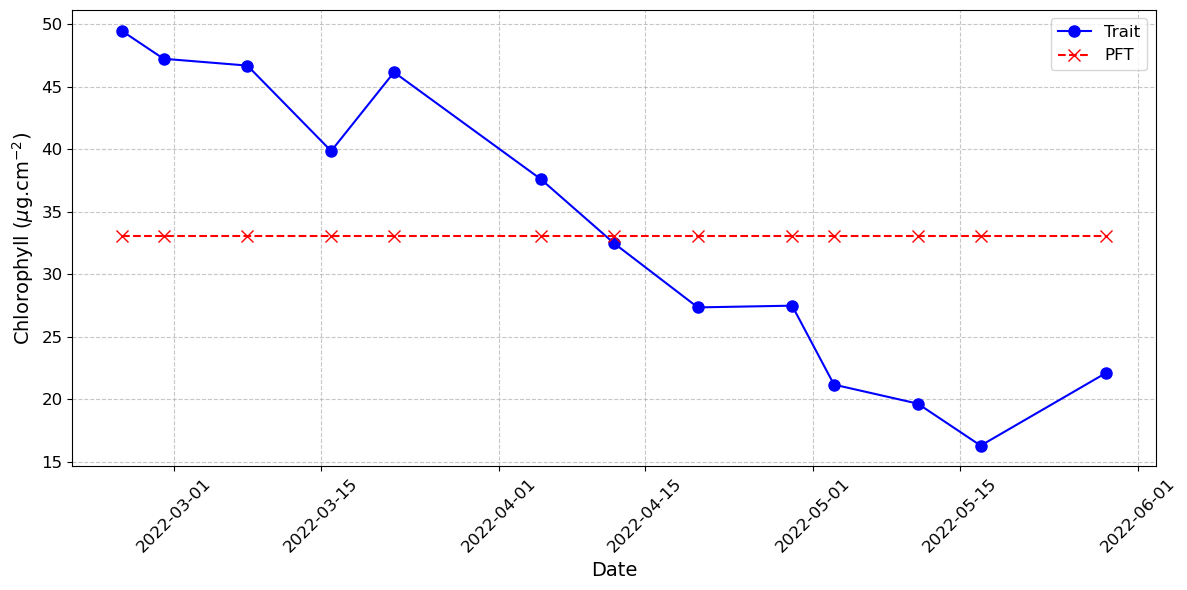

In [7]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/chl_aviris_dangermond_clima_fit_time_{}_reg.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/mean_masked_chl_aviris_dangermond_clima_fit.nc"

# Initialize lists to store mean Chl values for each dataset
mean_chl_trait = []
mean_chl_pft = []

# Convert string dates to pandas datetime objects
date_objects = [pd.to_datetime(date) for date in dates]

for i, date in enumerate(date_objects):
    file_trait = base_file_path_trait.format(str(i).zfill(2))
    file_pft = base_file_path_pft.format(str(i).zfill(2))

    # Open datasets
    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)

    # Extract Chl data and calculate mean, ignoring NaN values
    mean_chl_trait.append(ds_trait['chl'].mean().values)
    mean_chl_pft.append(ds_pft['chl'].mean().values)

# Plotting
plt.figure(figsize=(12, 6))  # Increase figure size for better presentation

# Customize line styles, colors, and markers
plt.plot(date_objects, mean_chl_trait, label='Trait', marker='o', linestyle='-', color='b', markersize=8)
plt.plot(date_objects, mean_chl_pft, label='PFT', marker='x', linestyle='--', color='r', markersize=8)

# Adding gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Formatting the plot
plt.xlabel('Date', fontsize=14)
plt.ylabel('Chlorophyll ($\mu$g.cm$^{-2}$)', fontsize=14)
#plt.title('Mean Chlorophyll Values Over Time', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/mean_chl_over_time.png', dpi=300)  # Increase DPI for high-quality output
plt.show()


PFT 2 covers 32.89% of the area
PFT 3 covers 37.95% of the area
PFT 4 covers 29.16% of the area


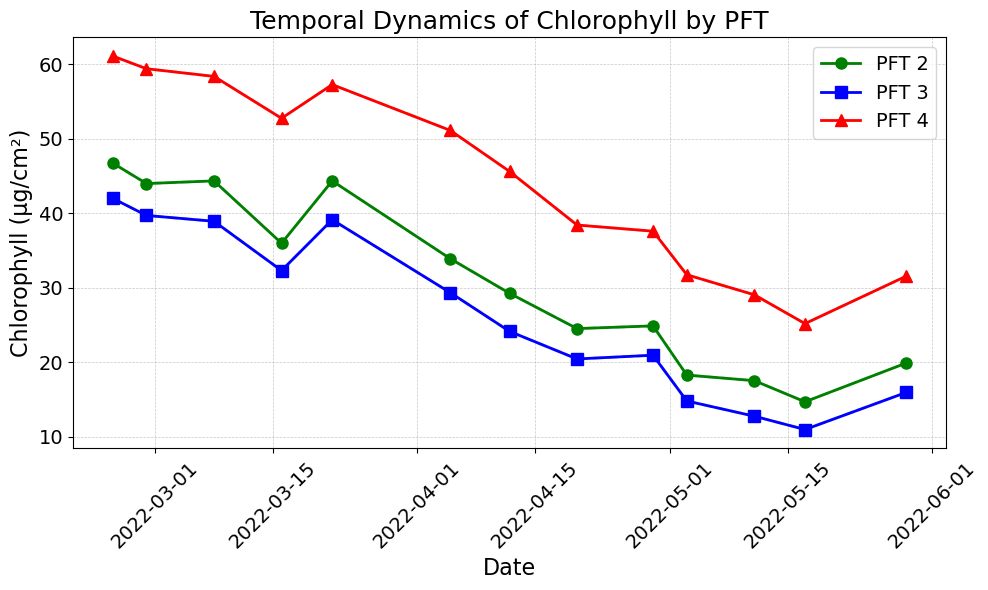

In [8]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Given color scheme
colors = ['g', 'b', 'r']  # Original colors for PFTs 2, 3, 4

dates = ["2022-02-24", "2022-02-28", "2022-03-08",
         "2022-03-16", "2022-03-22", "2022-04-05",
         "2022-04-12", "2022-04-20", "2022-04-29",
         "2022-05-03", "2022-05-11", "2022-05-17",
         "2022-05-29"]

pft_categories = [2, 3, 4]
markers = ['o', 's', '^']  # Different markers for each PFT
mean_chl_pft = {pft: [] for pft in pft_categories}

date_objects = [pd.to_datetime(date) for date in dates]

base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/"

pft_ds = xr.open_dataset('../California_Vegetation_WHRTYPE_Dangermond/output_latlon.nc')

# Calculate the percentage coverage for each PFT
pft_counts = np.array([(pft_ds['Band1'].values == pft).sum() for pft in pft_categories])
pft_totals = pft_counts.sum()
pft_percentages = (pft_counts / pft_totals) * 100

# Print the percentages covered by each PFT
for pft, percentage in zip(pft_categories, pft_percentages):
    print(f"PFT {pft} covers {percentage:.2f}% of the area")

for i, date in enumerate(date_objects):
    file_chl = f'{base_file_path}chl_aviris_dangermond_clima_fit_time_{str(i).zfill(2)}_reg.nc'
    
    ds_chl = xr.open_dataset(file_chl, decode_times=False)
    chl_values = ds_chl['chl'].values.flatten()
    pft_values = pft_ds['Band1'].values.flatten()

    for pft in pft_categories:
        pft_mask = pft_values == pft
        mean_chl_pft[pft].append(np.nanmean(chl_values[pft_mask]))

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed

# Plotting mean Chl for each PFT with different colors and markers
for pft, color, marker in zip(pft_categories, colors, markers):
    ax.plot(date_objects, mean_chl_pft[pft], marker=marker, linestyle='-', linewidth=2,
            markersize=8, color=color, label=f'PFT {pft}')  # Solid color for PFT

# Add more transparent lines for the trait data using a dashed line style
for pft, color, marker in zip(pft_categories, colors, markers):
    # Create a more transparent color for traits
    lighter_color = mcolors.to_rgba(color, alpha=0.3)
    ax.plot(date_objects, mean_chl_pft[pft], marker='', linestyle='--', linewidth=2,
            color=lighter_color, alpha=0.3)  # Transparent color for trait

ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Chlorophyll (μg/cm²)', fontsize=16)
ax.set_title('Temporal Dynamics of Chlorophyll by PFT', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis ticks

# Constrained layout for better spacing
plt.tight_layout()
plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/enhanced_mean_chl_over_time_by_pft_clima_fit.png', dpi=600)  # Use high dpi for publication quality
plt.show()


PFT 2 covers 32.89% of the area
PFT 3 covers 37.95% of the area
PFT 4 covers 29.16% of the area


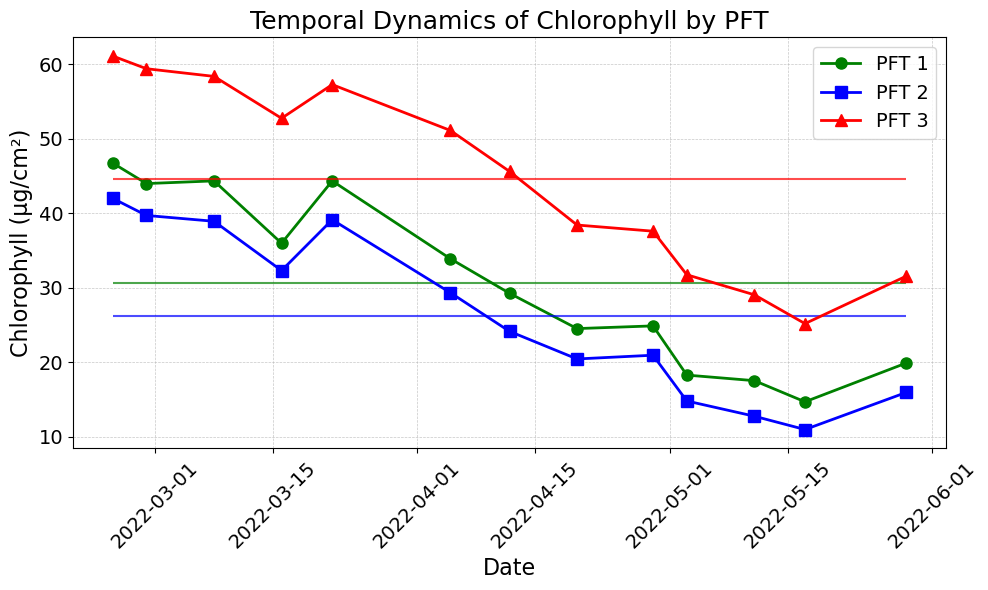

In [9]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Given color scheme
colors = ['g', 'b', 'r']  # Original colors for PFTs 2, 3, 4

dates = ["2022-02-24", "2022-02-28", "2022-03-08",
         "2022-03-16", "2022-03-22", "2022-04-05",
         "2022-04-12", "2022-04-20", "2022-04-29",
         "2022-05-03", "2022-05-11", "2022-05-17",
         "2022-05-29"]

pft_categories = [2, 3, 4]
markers = ['o', 's', '^']  # Different markers for each PFT
mean_chl_pft = {pft: [] for pft in pft_categories}

date_objects = [pd.to_datetime(date) for date in dates]

base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/datasets/clima_fit_prescribed_lai_ci/"

pft_ds = xr.open_dataset('../California_Vegetation_WHRTYPE_Dangermond/output_latlon.nc')

# Calculate the percentage coverage for each PFT
pft_counts = np.array([(pft_ds['Band1'].values == pft).sum() for pft in pft_categories])
pft_totals = pft_counts.sum()
pft_percentages = (pft_counts / pft_totals) * 100

# Print the percentages covered by each PFT
for pft, percentage in zip(pft_categories, pft_percentages):
    print(f"PFT {pft} covers {percentage:.2f}% of the area")

for i, date in enumerate(date_objects):
    file_chl = f'{base_file_path}chl_aviris_dangermond_clima_fit_time_{str(i).zfill(2)}_reg.nc'
    
    ds_chl = xr.open_dataset(file_chl, decode_times=False)
    chl_values = ds_chl['chl'].values.flatten()
    pft_values = pft_ds['Band1'].values.flatten()

    for pft in pft_categories:
        pft_mask = pft_values == pft
        mean_chl_pft[pft].append(np.nanmean(chl_values[pft_mask]))

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed

# Plotting mean Chl for each PFT with different colors and markers
for pft, color, marker in zip(pft_categories, colors, markers):
    ax.plot(date_objects, mean_chl_pft[pft], marker=marker, linestyle='-', linewidth=2,
            markersize=8, color=color, label=f'PFT {pft-1}')  # Solid color for PFT

    # Calculate the temporal average for each PFT
    temporal_average = np.nanmean(mean_chl_pft[pft])
    ax.hlines(temporal_average, date_objects[0], date_objects[-1], colors=color, linestyles='-', alpha=0.7)

ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Chlorophyll (μg/cm²)', fontsize=16)
ax.set_title('Temporal Dynamics of Chlorophyll by PFT', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis ticks

# Constrained layout for better spacing
plt.tight_layout()
plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/enhanced_mean_chl_over_time_by_pft_clima_fit.png', dpi=600)  # Use high dpi for publication quality
plt.show()


Plot created successfully with mean LMA values.


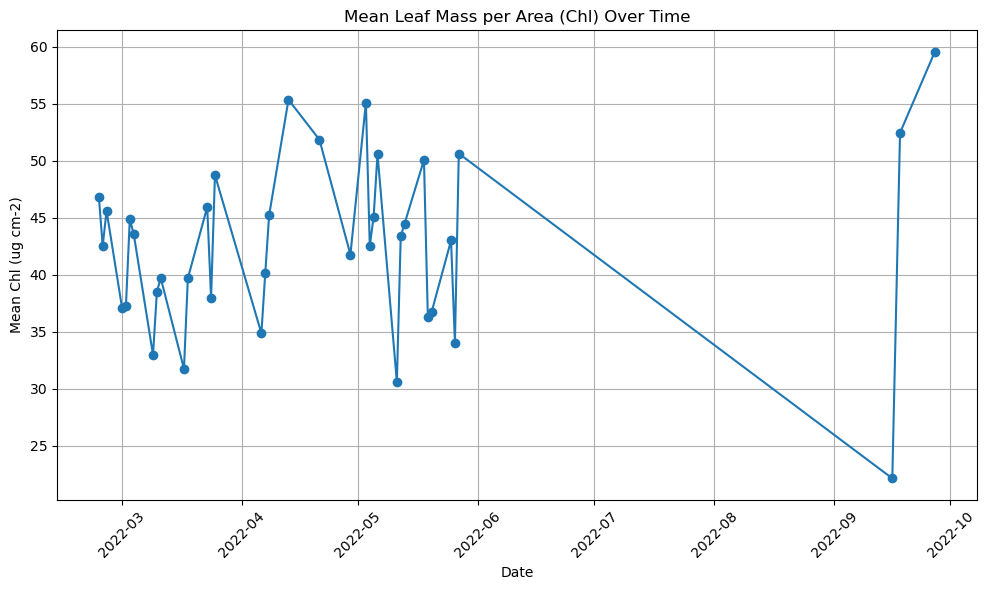

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you've already uploaded the CSV file and it's named 'SHIFT_Leaf_Traits_Chl.csv'
csv_file = '/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/orders/b74733107ab240e64f230e7bb4bfce48/SHIFT_Leaf_Traits_Chl_SB_CA/data/SHIFT_Leaf_Traits_LMA_LWC_Chl.csv'  # Replace with your CSV file path

# Read the CSV file
data = pd.read_csv(csv_file)

# Convert the 'sample_date' column to datetime
data['sample_date'] = pd.to_datetime(data['sample_date'])

# Remove rows with negative LMA values
data = data[data['CHL'] > 0]

# Group the data by 'sample_date' and calculate the mean of the LMA values for each date
mean_lma_by_date = data.groupby('sample_date')['CHL'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mean_lma_by_date['sample_date'], mean_lma_by_date['CHL']*0.1, marker='o', linestyle='-')
plt.title('Mean Leaf Mass per Area (Chl) Over Time')
plt.xlabel('Date')
plt.ylabel('Mean Chl (ug cm-2)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()

# Save or show the plot
plt.savefig('mean_chl_time_plot.png')  # Save the plot as a PNG file
# plt.show()  # Uncomment to display the plot instead

print("Plot created successfully with mean LMA values.")


In [11]:
from PIL import Image
import os

# Directory containing the PNG images
image_directory = '/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/'

# Output GIF file name
output_gif = 'combined_chl_map_trait.gif'

# List of PNG files in the directory
png_files = [f for f in os.listdir(image_directory) if f.startswith('chl_') and f.endswith('_trait_map.png')]
png_files.sort()  # Sort the files in ascending order by filename

# Create a list to store image frames
frames = []

# Open and append each PNG image to the frames list
for png_file in png_files:
    image_path = os.path.join(image_directory, png_file)
    img = Image.open(image_path)
    frames.append(img)

# Save the frames as an animated GIF
frames[0].save(output_gif, save_all=True, append_images=frames[1:], duration=500, loop=0)

print(f'GIF saved as {output_gif}')


GIF saved as combined_chl_map_trait.gif
